In [4]:
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [5]:
def init_params(nx, nh, ny):
    # Initialize weights for the neural network with small random values.
    # nx: number of input features
    # nh: number of hidden units
    # ny: number of output classes
    W1 = np.random.normal(0, 0.3, (nh, nx + 1))  # Weights for input to hidden layer, including bias
    W2 = np.random.normal(0, 0.3, (ny, nh + 1))  # Weights for hidden to output layer, including bias
    params = {'W1': W1, 'W2': W2}
    return params

def tanh(x):
    # Hyperbolic tangent activation function
    result = np.tanh(x)
    return result

def softmax(x):
    # Softmax activation function used for output layer
    # Ensures output values are between 0 and 1 and sum to 1
    result = np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True) # Improve stability by subtracting max
    return result

def forward(params, X):
    # Forward propagation through the network
    # params: dictionary containing network weights
    # X: input data
    W1 = params['W1']
    W2 = params['W2']     

    # add bias column because the matrix will be transposed
    ones_vector = np.ones(X.shape[0])
    A0 = np.insert(X, 0, ones_vector, axis=1)
    Z1 = np.matmul(W1, A0.transpose())
    A1 = tanh(Z1)

    # add bias row because the matrix won't be transposed
    ones_vector = np.ones(A1.shape[1])
    A1 = np.insert(A1, 0, ones_vector, axis=0)
    Z2 =np.matmul(W2, A1)
    A2 = softmax(Z2)

    outputs = {'A0': A0, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return outputs

def loss_accuracy(y_pred, y):
    # Calculate cross-entropy loss and accuracy
    loss = -np.mean(np.sum(y * np.log(y_pred), axis=1))
    accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
    return loss, accuracy

def tanh_derivative(x):
    # Derivative of hyperbolic tangent function used in backpropagation
    result = 1 - np.tanh(x) ** 2
    return result

def backward(X, params, outputs, Y):
    # Backward propagation to calculate gradients
    X = np.vstack([np.ones(X.shape[0]), X.T]) # Add bias to input

    d2 = outputs['A2'] - Y.T # Error in output
    dW2 = np.matmul(d2, outputs['A1'].T) # Gradient for W2

    d1 = np.matmul(params['W2'].T[1:], d2) * tanh_derivative(outputs['Z1'])
    dW1 = np.matmul(d1, X.T) # Gradient for W1

    grads = {'dW1': dW1, 'dW2': dW2}
    return grads

def sgd(params, grads, eta):
    # Stochastic gradient descent to update parameters
    params['W1'] -= eta * grads['dW1']
    params['W2'] -= eta * grads['dW2']
    return params

def one_hot_encoding(y, max):
    # One-hot encoding of labels
    result = np.eye(max)[y]
    return result

def one_hot_decoding(y):
    # Decoding one-hot encoded predictions
    result = np.argmax(y, axis=0).reshape((1,-1))
    return result

In [6]:
mnist_train = pd.read_csv('mnist_train.csv')
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(f"The shape of the training set is: {mnist_train.shape[0]} x {mnist_train.shape[1] - 1}")

The shape of the training set is: 60000 x 784


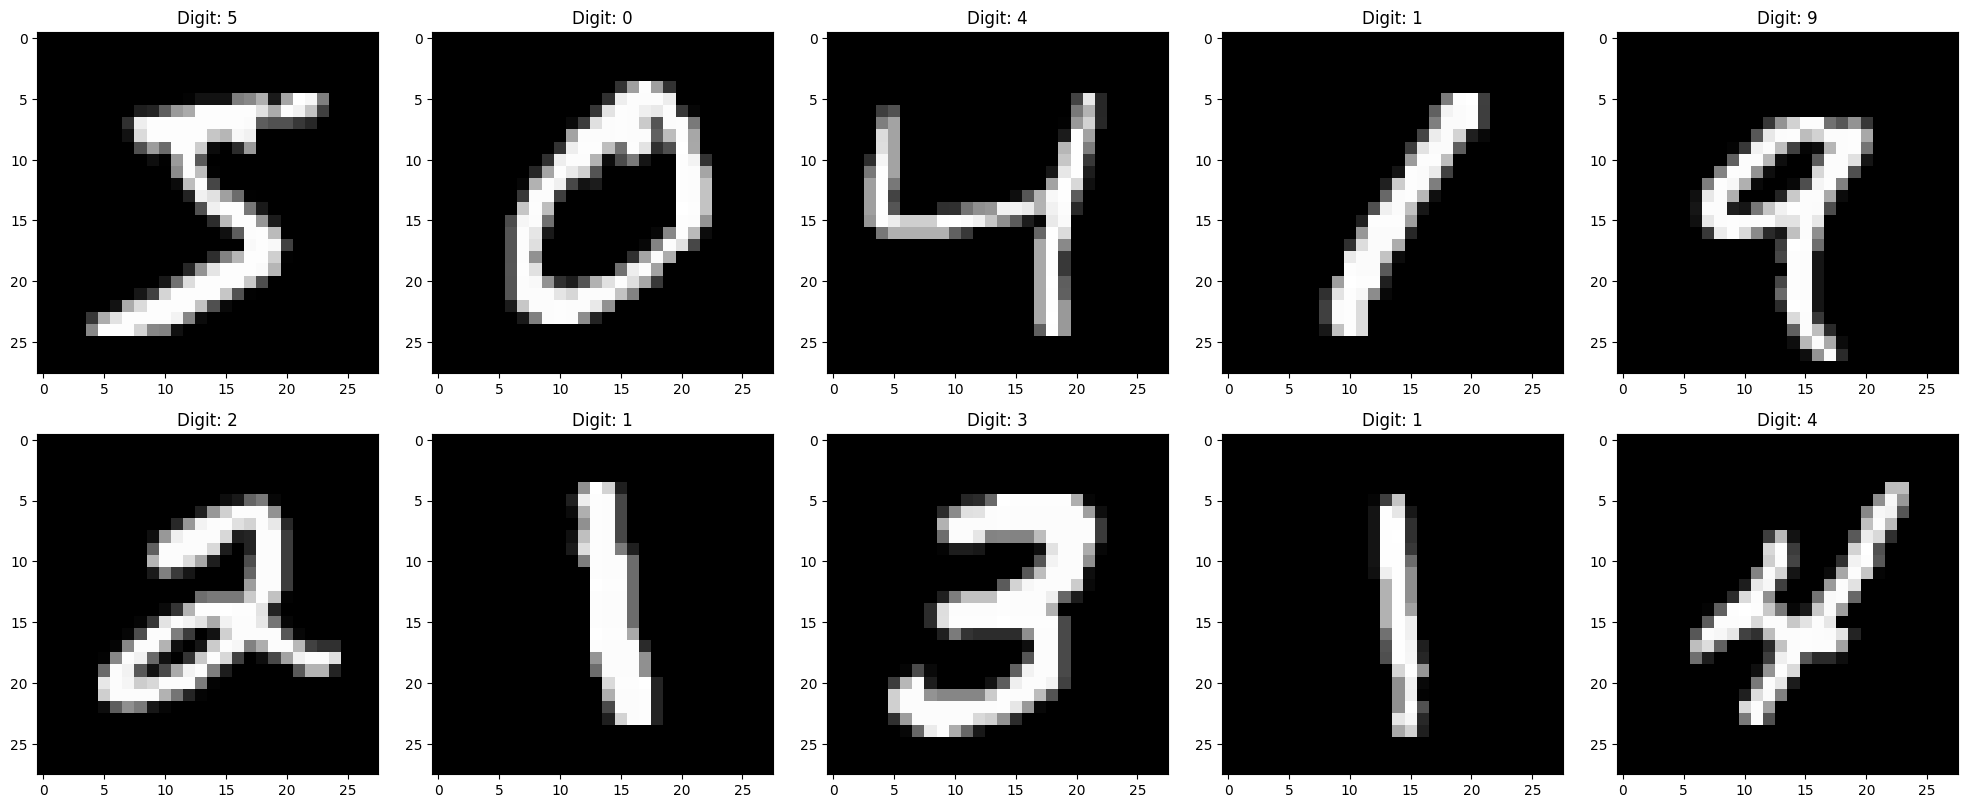

In [8]:
label = np.array(mnist_train.iloc[:,0])

# Extract the image data from the remaining columns, convert to float32 for processing
images = mnist_train.iloc[:,1:].values.astype('float32')

# Create a figure with specified size to host the image subplots
fig = plt.figure(figsize=(20,20))

# Loop to create subplots for displaying the first 10 images
for i in range(10):
    # Add a subplot in a grid with 5 rows and 5 columns at position i+1
    ax = fig.add_subplot(5, 5, i+1)
    
    # Display an image reshaped to 28x28 pixels (since MNIST images are 28x28),
    # use a grayscale color map as these are hand-written digit images
    ax.imshow(np.reshape(images[i], (28,28)), cmap='gray')
    
    # Adjust layout to prevent overlapping subplots
    plt.tight_layout()
    
    # Set a title for each subplot showing the digit label
    ax.set_title("Digit: {}".format(label[i]))

# Display the plot
plt.show()

In [9]:
X_train = mnist_train.drop(['label'], axis=1)
y_train = np.array(mnist_train['label'])

In [10]:
# Normalizing the RGB codes by dividing it to the max RGB value(255)
X_train = X_train / 255

In [11]:
max = np.unique(y_train).size
y_train = one_hot_encoding(y_train, max)

In [12]:
def train(X, y, hidden, batch_size, num_epochs, num_batches, learning_rate, history=False):

    # Initialize the network parameters
    params = init_params(X.shape[1], hidden, y.shape[1])

    loss_hist = np.array([])
    accuracy_hist = np.array([])

    for i in range(num_epochs):

        # shuffle the data
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X.iloc[indices]
        y = y[indices]

        start_timer = time.time()
    
        for j in range(num_batches):

            # Load a batch of data
            start = j * batch_size
            end = start + batch_size
            x_batch = X[start:end]
            y_batch = y[start:end]
            # Forward pass
            outputs = forward(params, x_batch)
            # Compute loss and accuracy
            loss, accuracy = loss_accuracy(outputs['A2'].T, y_batch)
            if j % 50 == 0:
                loss_hist = np.append(loss_hist, loss)
                accuracy_hist = np.append(accuracy_hist, accuracy)
            # Backward pass
            grads = backward(x_batch, params, outputs, y_batch)
            # Update the parameters
            params = sgd(params, grads, learning_rate)
        
        end_timer = time.time()
        
        if history:
            print(f"• Epoch {str(i+1).zfill(2)}: loss = {loss:.3f} | accuracy = {accuracy:.3f} | time = {end_timer - start_timer:.3f} seconds")
    
    print("✅ Training complete!")

    return params, loss_hist, accuracy_hist

In [13]:
def plot_loss_accuracy(loss, accuracy, title='Loss & Accuracy history curves'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    ax[0].plot(loss, label='Training Loss', color='blue')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(accuracy, label='Training Accuracy', color='green')
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

In [14]:
learning_rate = 0.01
batch_size = 128
epochs = 50
batches = X_train.shape[0] // batch_size

In [15]:
# Train the model using the training data, specified number of hidden units, batch size, number of epochs, 
# number of batches per epoch, and learning rate. 
# The `history` parameter being `True` implies that the training process will return histories of loss and accuracy.
Weights_32, train_loss, train_accuracy = train(
    X_train,       # Input features for training
    y_train,       # True labels for the training data
    32,            # Number of hidden units in the neural network
    batch_size,    # Number of samples per batch to be used for training
    epochs,        # Total number of iterations over the entire training data
    batches,       # Number of batches to process as part of the training
    learning_rate, # Learning rate for optimizer
    history=True   # Flag to indicate recording of loss and accuracy history
)

• Epoch 01: loss = 0.180 | accuracy = 0.945 | time = 0.910 seconds
• Epoch 02: loss = 0.218 | accuracy = 0.938 | time = 0.914 seconds
• Epoch 03: loss = 0.192 | accuracy = 0.938 | time = 0.854 seconds
• Epoch 04: loss = 0.060 | accuracy = 0.984 | time = 0.981 seconds
• Epoch 05: loss = 0.159 | accuracy = 0.969 | time = 0.757 seconds
• Epoch 06: loss = 0.155 | accuracy = 0.938 | time = 0.857 seconds
• Epoch 07: loss = 0.109 | accuracy = 0.945 | time = 0.732 seconds
• Epoch 08: loss = 0.071 | accuracy = 0.984 | time = 0.843 seconds
• Epoch 09: loss = 0.129 | accuracy = 0.961 | time = 0.752 seconds
• Epoch 10: loss = 0.028 | accuracy = 0.992 | time = 0.796 seconds
• Epoch 11: loss = 0.073 | accuracy = 0.984 | time = 1.094 seconds
• Epoch 12: loss = 0.047 | accuracy = 0.992 | time = 1.161 seconds
• Epoch 13: loss = 0.074 | accuracy = 0.984 | time = 0.804 seconds
• Epoch 14: loss = 0.114 | accuracy = 0.969 | time = 1.314 seconds
• Epoch 15: loss = 0.100 | accuracy = 0.969 | time = 0.741 sec

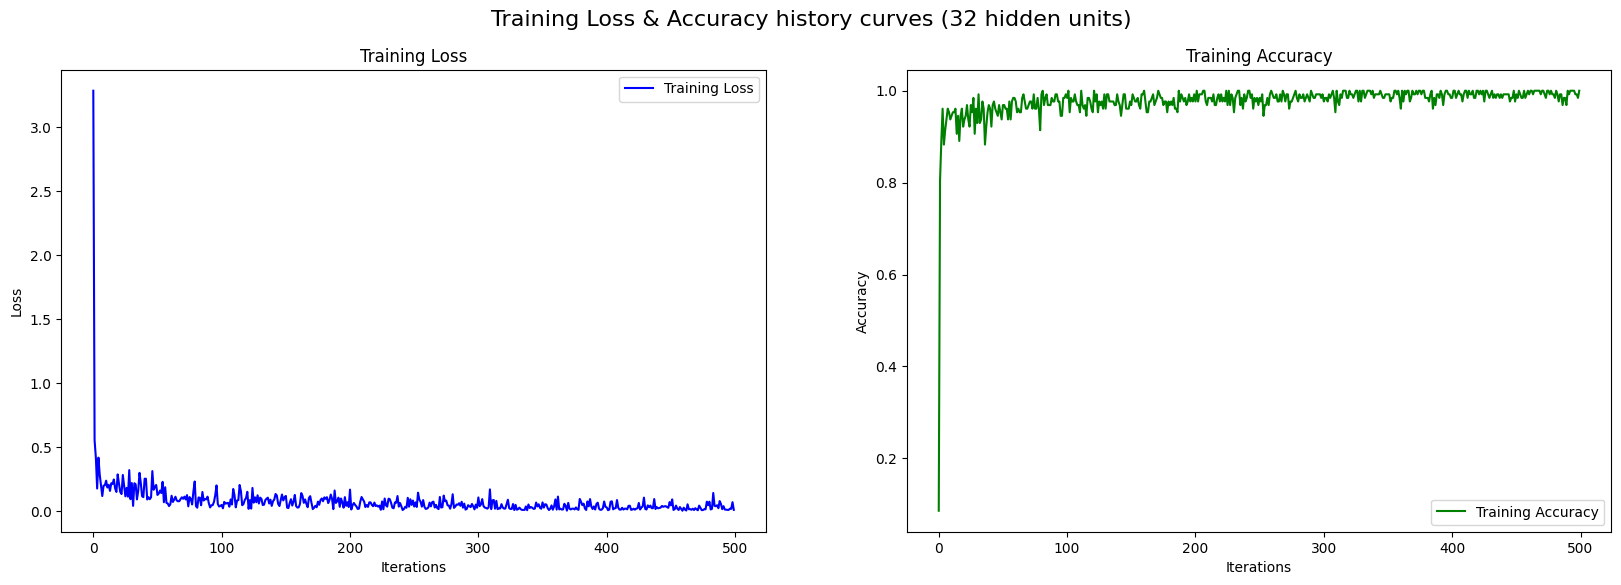

In [16]:
# Function to plot training loss and accuracy over epochs. Helps in visualizing the learning process.
plot_loss_accuracy(
    train_loss,    # Training loss history obtained from the training function
    train_accuracy,# Training accuracy history obtained from the training function
    title='Training Loss & Accuracy history curves (32 hidden units)'  # Title of the plot
)

In [17]:
# Same is repeated for 64, 128, 256, 512 and 1024

Weights_64, train_loss, train_accuracy = train(X_train, y_train, 64, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


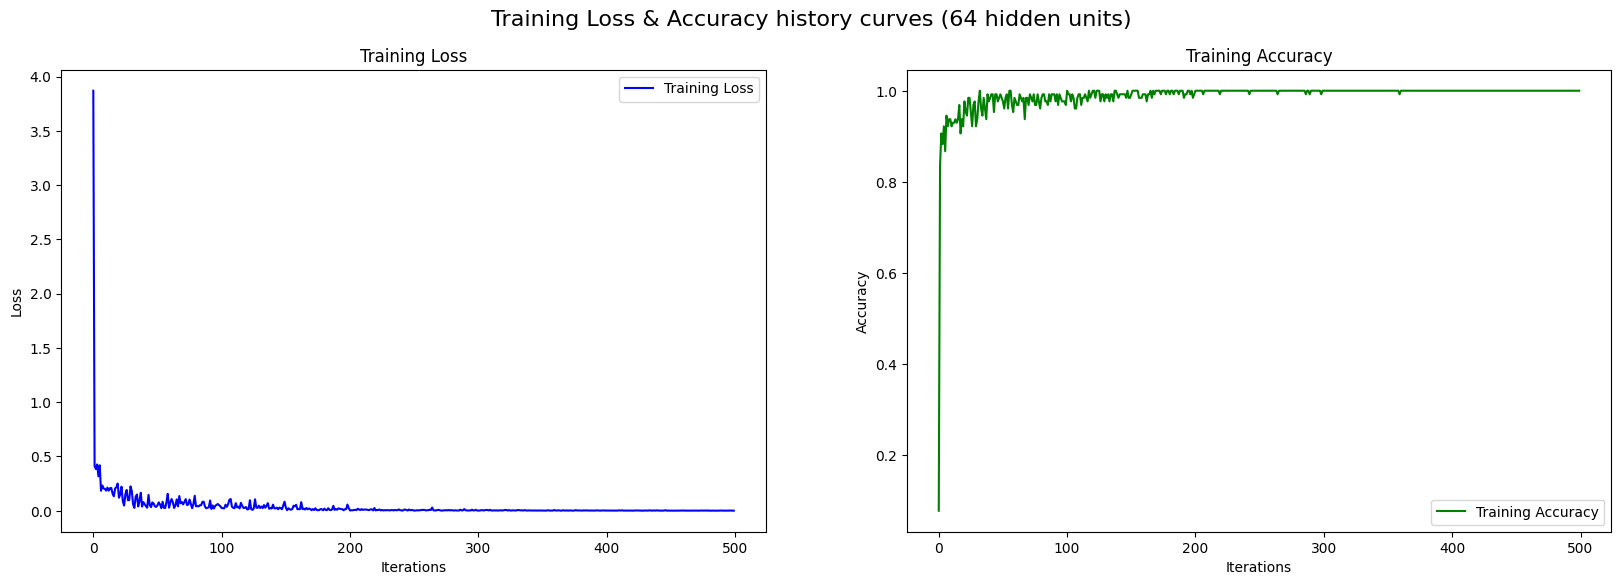

In [18]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (64 hidden units)')

In [19]:
Weights_128, train_loss, train_accuracy = train(X_train, y_train, 128, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


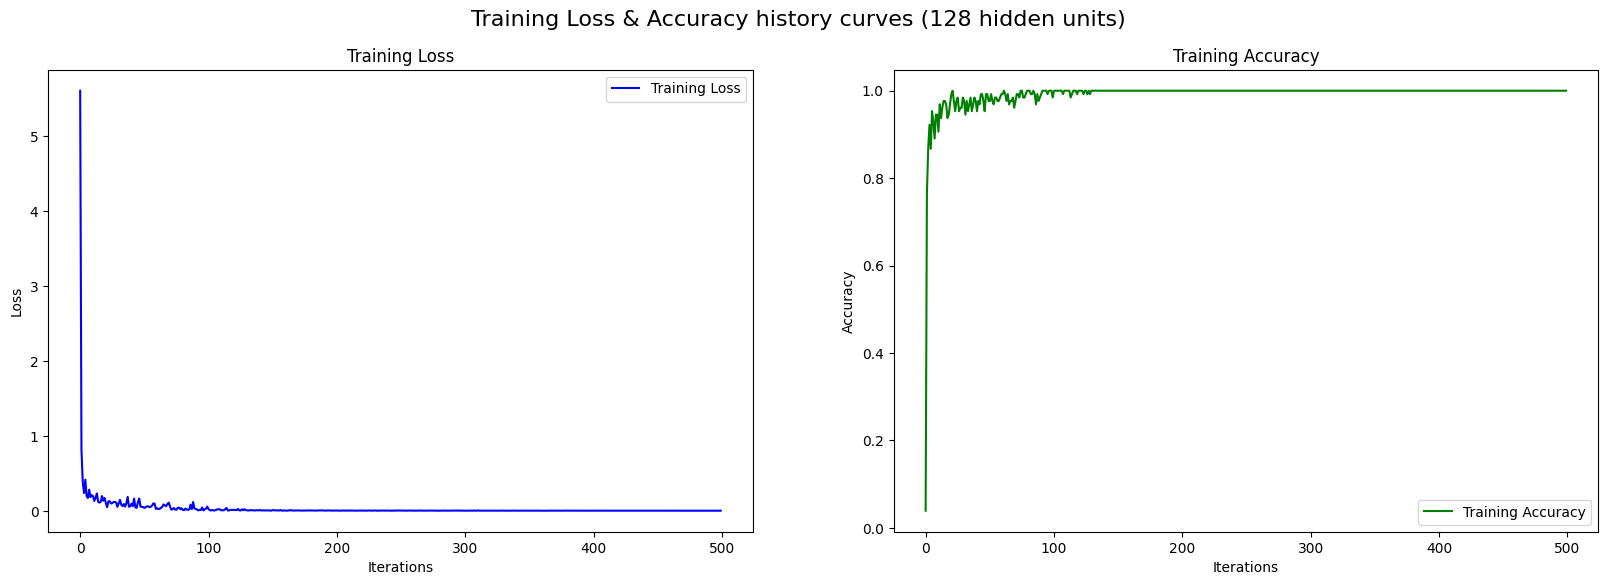

In [20]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (128 hidden units)')

In [21]:
Weights_256, train_loss, train_accuracy = train(X_train, y_train, 256, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


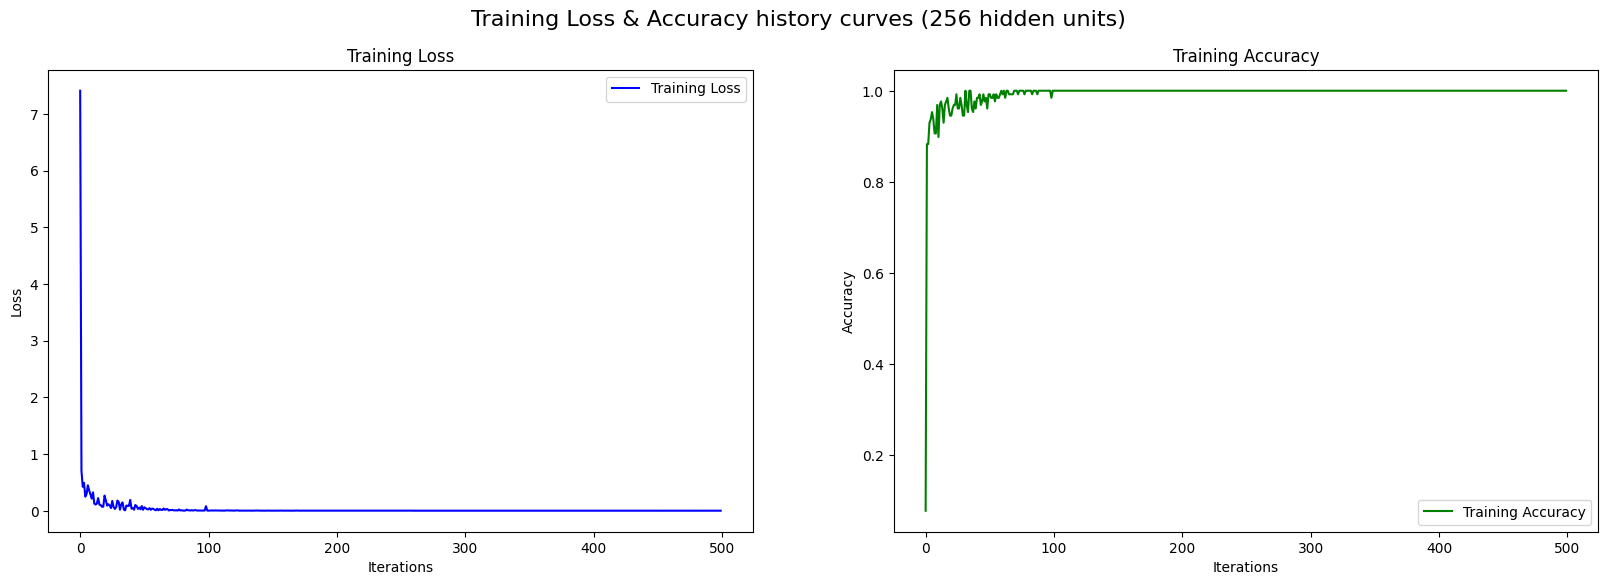

In [22]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (256 hidden units)')

In [23]:
Weights_512, train_loss, train_accuracy = train(X_train, y_train, 512, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


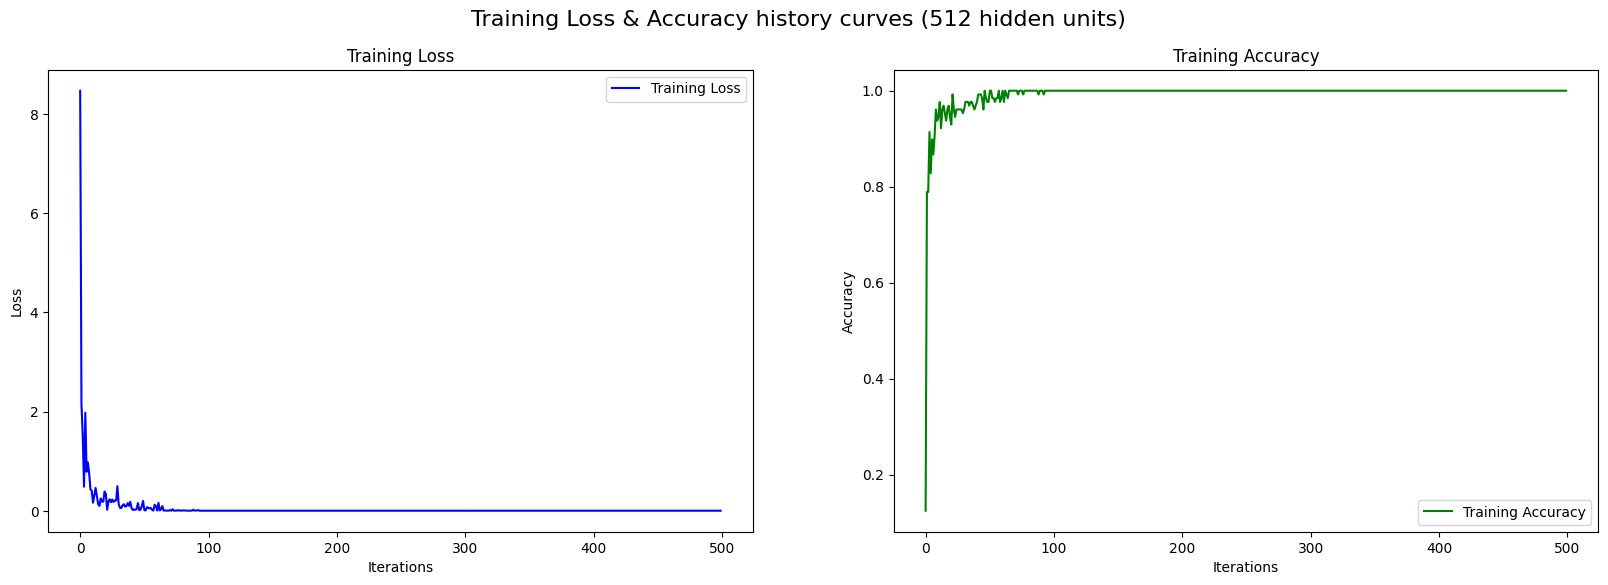

In [24]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (512 hidden units)')

In [25]:
Weights_1024, train_loss, train_accuracy = train(X_train, y_train, 1024, batch_size, epochs, batches, learning_rate, history=False)

✅ Training complete!


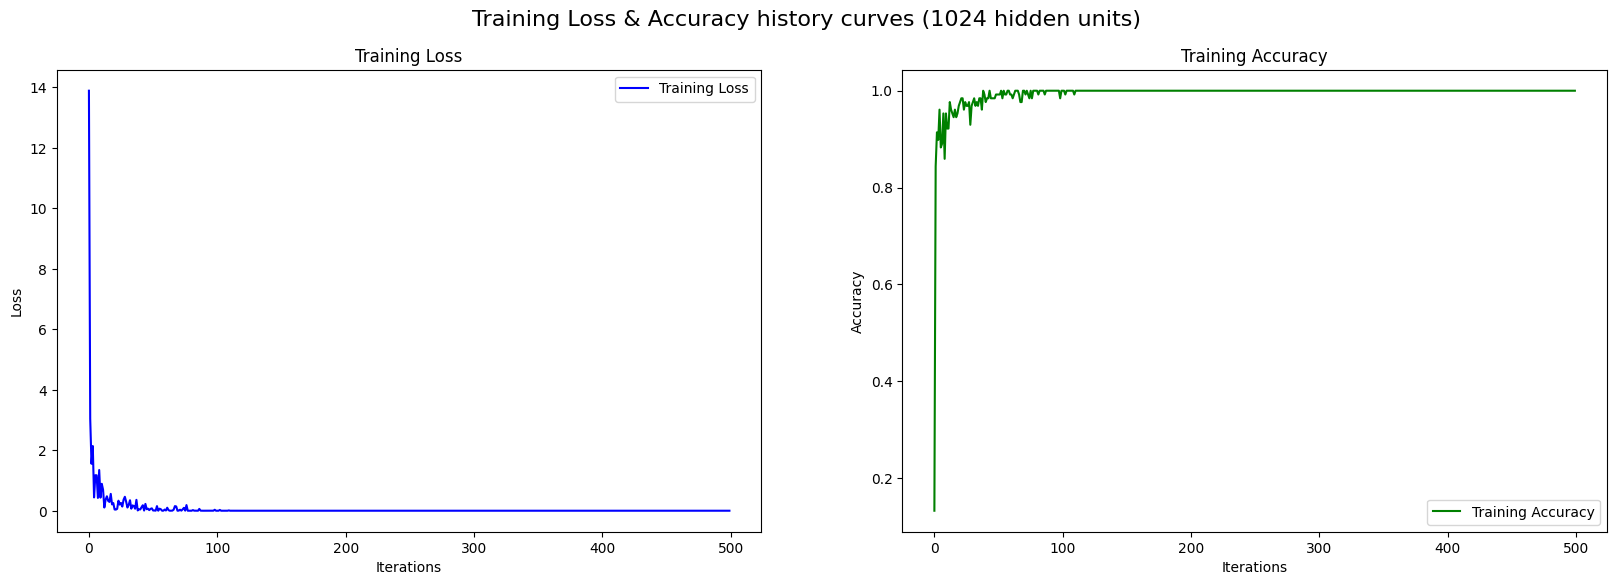

In [26]:
plot_loss_accuracy(train_loss, train_accuracy, title='Training Loss & Accuracy history curves (1024 hidden units)')

In [27]:
mnist_test = pd.read_csv('mnist_test.csv')
X_test = mnist_test.drop(['label'], axis=1)
y_test = mnist_test['label']

In [28]:
print(f"The shape of the testing set is: {mnist_test.shape[0]} x {mnist_test.shape[1] - 1}")

The shape of the testing set is: 10000 x 784


In [29]:
X_test = X_test / 255
y_test = np.reshape(y_test, (1,-1))

In [30]:
# Perform forward propagation using the network weights for 32 hidden units and test input data
outputs = forward(Weights_32, X_test)
# Decode the one-hot encoded predictions to class labels
y_pred_32 = one_hot_decoding(outputs['A2'])

# Repeat the process for model with 64 hidden units
outputs = forward(Weights_64, X_test)
y_pred_64 = one_hot_decoding(outputs['A2'])

# Repeat the process for model with 128 hidden units
outputs = forward(Weights_128, X_test)
y_pred_128 = one_hot_decoding(outputs['A2'])

# Repeat the process for model with 256 hidden units
outputs = forward(Weights_256, X_test)
y_pred_256 = one_hot_decoding(outputs['A2'])

# Repeat the process for model with 512 hidden units
outputs = forward(Weights_512, X_test)
y_pred_512 = one_hot_decoding(outputs['A2'])

# Repeat the process for model with 1024 hidden units
outputs = forward(Weights_1024, X_test)
y_pred_1024 = one_hot_decoding(outputs['A2'])

In [31]:
# Create a DataFrame to store evaluation metrics for different models
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])

# List of predictions from models with different numbers of hidden units
predictions = [y_pred_32[0], y_pred_64[0], y_pred_128[0], y_pred_256[0], y_pred_512[0], y_pred_1024[0]]

# Loop through the predictions list to compute metrics for each model configuration
for i in range(6):
    # Generate a classification report for each set of predictions against the true labels
    report_df = pd.DataFrame(classification_report(y_test[0], predictions[i], output_dict=True)).T
    
    # Extract the overall accuracy, and the macro-average recall, precision, and F1-score
    accuracy = report_df.loc['accuracy', 'precision']  # In the report, 'precision' column of 'accuracy' row holds the overall accuracy
    recall = report_df.loc['macro avg', 'recall']
    precision = report_df.loc['macro avg', 'precision']
    f1_score = report_df.loc['macro avg', 'f1-score']
    
    # Append the extracted metrics into the DataFrame for each model configuration
    metrics_df.loc[i] = ['MLP-' + str([32, 64, 128, 256, 512, 1024][i]), accuracy, recall, precision, f1_score]

# Display the metrics DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score
0,MLP-32,0.9584,0.957735,0.958226,0.957919
1,MLP-64,0.9666,0.966278,0.966392,0.966285
2,MLP-128,0.9701,0.969796,0.969786,0.969783
3,MLP-256,0.9745,0.974394,0.974336,0.974355
4,MLP-512,0.9746,0.974315,0.974405,0.974332
5,MLP-1024,0.9792,0.979006,0.979099,0.979041


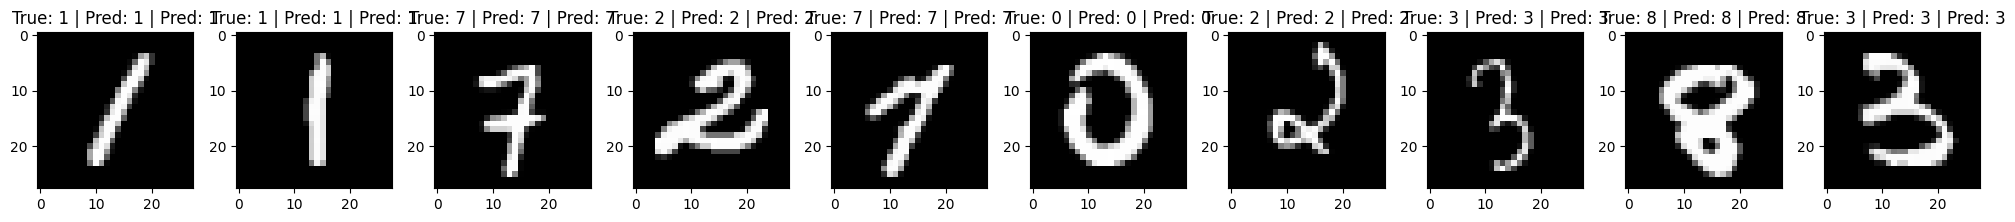

In [32]:
# Randomly select 10 indices from the test dataset
indices = np.random.choice(X_test.shape[0], 10)
# Extract the images at these indices
images = X_test.iloc[indices].values.astype('float32')
# Extract the corresponding labels
labels = y_test[0][indices]

# Generate predictions using the model with 32 hidden units and decode them
y_hat_32 = forward(Weights_32, images)['A2']
y_hat_32 = one_hot_decoding(y_hat_32)

# Repeat for models with 64, 128, 256, 512, and 1024 hidden units
y_hat_128 = forward(Weights_128, images)['A2']
y_hat_128 = one_hot_decoding(y_hat_128)
y_hat_1024 = forward(Weights_1024, images)['A2']
y_hat_1024 = one_hot_decoding(y_hat_1024)

# Create a figure with specified size
fig = plt.figure(figsize=(20,20))

# Loop through each of the 10 selected samples
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)  # Add subplot in a row of 10
    ax.imshow(np.reshape(images[i], (28,28)), cmap='gray')  # Display image in grayscale
    plt.tight_layout()  # Adjust layout to prevent overlap
    # Set the title of each subplot with true label and predictions from each model
    ax.set_title(f"True: {labels[i]} | Pred: {y_hat_128[0][i]} | Pred: {y_hat_1024[0][i]}")

plt.show()  # Display the figure